<a href="https://colab.research.google.com/github/mumerabbasi/NLP/blob/main/Multi_Label_Classification_with_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# Importing libraries
import numpy as np
import pandas as pd
import tensorflow as tf

# Importing keras from tensor flow to use Google Colab's TPU (To accelerate training)
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Embedding, SpatialDropout1D, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Importing libraries required for cleaning text
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings

# Importing for tokenizing our reviews
from keras.preprocessing.text import Tokenizer

In [23]:
# To import data file from your google drive.
from google.colab import drive
drive.mount('/content/gdrive')
path = 'gdrive/My Drive/Colab Notebooks/data.csv'  # gdrive/My Drive/Folder Name/File Name.csv

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [24]:
# Reading data from file into a Pandas DataFrame
df =  pd.read_csv(path, sep='<')
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,stars_str,txt_len,sent_label,sent_score
0,i1buEuYYo9CvosniQ64DJg,K0HrAbJrNfceo3tk1VOWiw,yn76xXVpL6Ejt47HqJ0YiQ,1,0,1,0,I see the owner finally decided to reply to so...,2019-05-23 21:04:21,1,2958,-1,0.999629
1,oyqPnwGQaOL9-n8Z1YmcDA,fMX9IsFT5awrkNaZJnEv3A,n85oc0lNQhEDomqhljmZqg,1,1,0,0,Just gross. I had the 'crispy' chicken sandwic...,2017-11-19 21:28:29,1,352,-1,0.999609
2,0Bfai921X7GUt4U2xLcYSQ,jMqD6Sl_3Msi53aVA0KTRg,AvXqLbcGCxdIEF_qZTY0Kw,1,1,0,0,I saw this restaurant on TV. So it was on my l...,2014-07-15 14:40:29,1,640,-1,0.999689
3,AaZwkwIMO0vw-sQvp1S2IA,0FZW665jtUeVa_Nej6h_gA,tMnK-Pip_N_XiGo4wPjegQ,1,2,0,0,Ordered $45 worth of food through Grubhub- two...,2016-03-01 00:41:09,1,683,-1,0.999553
4,0ZuDXldIHDj-o-hew4IjCQ,Bn6lNYr5fSgl1WmeNenGvA,JX-7i6KGbqejH1JBBzv5JQ,1,1,0,0,My girlfriend and went to the AMC Loews theate...,2014-10-05 13:21:44,1,960,-1,0.999554


In [25]:
# Dropping unecessary columns.
df.drop(['review_id', 'user_id','business_id','date','stars_str','sent_label','sent_score'], axis=1, inplace = True)
df.describe(include = 'all')

,stars,useful,funny,cool,text,txt_len
count,250000.000000,250000.000000,250000.000000,250000.000000,250000,250000.000000
unique,NaN,NaN,NaN,NaN,249931,NaN
top,NaN,NaN,NaN,NaN,We had a problem with scorpions and a baby on ...,NaN
freq,NaN,NaN,NaN,NaN,2,NaN
mean,3.000000,1.182124,0.364612,0.340844,NaN,659.425792
std,1.414216,2.040491,0.957347,0.900329,NaN,588.503640
min,1.000000,0.000000,0.000000,0.000000,NaN,50.000000
25%,2.000000,0.000000,0.000000,0.000000,NaN,271.000000
50%,3.000000,0.000000,0.000000,0.000000,NaN,484.000000
75%,4.000000,2.000000,0.000000,0.000000,NaN,847.000000


In [26]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Function for cleaning HTML
def clean_Html(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext

# Function for cleaning Punctuation/Special Characters
def clean_Punc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

# Function for cleaning Uppercase letters
def keep_Alpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

# Function for stemming
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

# Applying these functions to our DataFrame
df['text'] = df['text'].str.lower()
df['text'] = df['text'].apply(clean_Html)
df['text'] = df['text'].apply(clean_Punc)
df['text'] = df['text'].apply(keep_Alpha)
df['text'] = df['text'].apply(stemming)

df.head()

,stars,useful,funny,cool,text,txt_len
0,1,0,1,0,i see the owner final decid to repli to someon...,2958
1,1,1,0,0,just gross i had the crispi chicken sandwich i...,352
2,1,1,0,0,i saw this restaur on tv so it was on my list ...,640
3,1,2,0,0,order worth of food through grubhub two dinner...,683
4,1,1,0,0,my girlfriend and went to the amc loew theater...,960


In [27]:
# Performing Tokenization
max_num_words = 50000 # Maximum number of the most frequents words to be used
max_len = 1500 # Max number of words in each review.
embedding_dim = 100

tokenizer = Tokenizer(num_words=max_num_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)

In [28]:
# Padding reviews to make them have equal length
from keras.preprocessing.sequence import pad_sequences

x = tokenizer.texts_to_sequences(df['text'].values)
x = pad_sequences(x, maxlen=max_len)

In [29]:
# Dividing labels into more labels depending upon the label value
df['useful'] = pd.cut(df['useful'], bins=[0, 6, 12, 19], include_lowest=True, labels=['not useful', 'useful', 'very useful'])
df['funny'] = pd.cut(df['funny'], bins=[0, 3, 6, 10], include_lowest=True, labels=['not funny', 'funny', 'very funny'])
df['cool'] = pd.cut(df['cool'], bins=[0, 3, 6, 10], include_lowest=True, labels=['not cool', 'cool', 'very cool'])

# Performing OneHot Encoding of labels
y = pd.get_dummies(data=df[['useful','funny','cool']], columns=['useful', 'funny', 'cool']).values
print('Shape of label tensor:', y.shape)

Shape of label tensor: (250000, 9)


In [35]:
# Splitting dataset into Train and Test datasets in 70:30
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.30)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(175000, 1500) (175000, 9)
(75000, 1500) (75000, 9)


In [34]:
# configuring Google Colabs's TPU for model training
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.95.235.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.95.235.82:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [63]:
# Enabling Google Colabs's TPU
with tpu_strategy.scope():
  # Building a GRU Model
  model = Sequential()
  model.add(Embedding(max_num_words, embedding_dim, input_length=x.shape[1]))
  model.add(SpatialDropout1D(0.2))
  model.add(GRU(100, dropout=0.4, recurrent_dropout=0.4))
  model.add(Dense(9, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  epochs = 5
  batch_size = 64
  # Training a GRU model on Colab's TPU
  GRU_Model = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
2461/2461 [==============================] - 794s 319ms/step - loss: 6.9843 - accuracy: 0.9637 - val_loss: 9.2652 - val_accuracy: 0.9707
Epoch 2/5
2461/2461 [==============================] - 780s 317ms/step - loss: 12.2488 - accuracy: 0.9696 - val_loss: 14.1731 - val_accuracy: 0.9707
Epoch 3/5
2461/2461 [==============================] - 781s 317ms/step - loss: 17.4233 - accuracy: 0.9696 - val_loss: 18.8929 - val_accuracy: 0.9707
Epoch 4/5
2461/2461 [==============================] - 780s 317ms/step - loss: 22.4640 - accuracy: 0.9696 - val_loss: 24.1184 - val_accuracy: 0.9707


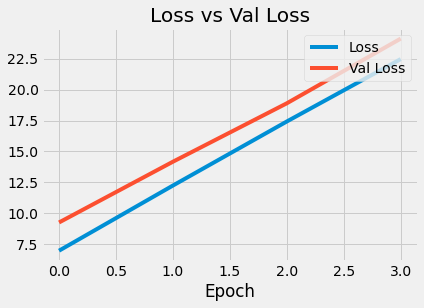

In [65]:
plt.plot(GRU_Model.history['loss'])
plt.plot(GRU_Model.history['val_loss'])
plt.title('Loss vs Val Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Val Loss'], loc='upper right')
plt.show()

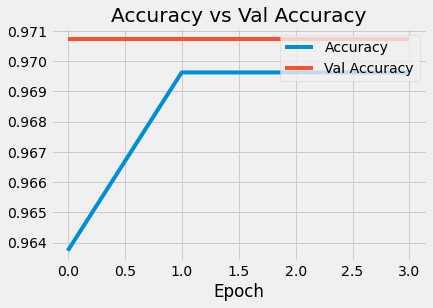

In [67]:
plt.plot(GRU_Model.history['accuracy'])
plt.plot(GRU_Model.history['val_accuracy'])
plt.title('Accuracy vs Val Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Val Accuracy'], loc='upper right')
plt.show()

In [69]:
# Evaluting model on Test Set
test = model.evaluate(x_test,y_test)
print('For Test Set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(test[0], test[1]))

2344/2344 [==============================] - 121s 51ms/step - loss: 24.9596 - accuracy: 0.9703
For Test Set
  Loss: 24.960
  Accuracy: 0.970
